# Уравнение переноса

Перенос - один из важнейших в атмосфере. Перемещаясь воздух переносит с собой свои характеристики - температуру, влажность, концентрации пыли и других веществ, даже свою скорость!

Рассмотрим кубик воздуха, который движется "по воле ветра". Пусть в этом кубике концентрация озона (например, но может быть любая) $u$ моль/моль воздуха. Обратите внимание на размерность концентрации - она безразмерна, это количество молей озона в кубике, поделенное на количество молей воздуха в кубике.

Предположим, что сейчас никаких химических реакций нет и количество озона в кубике не меняется. Количество воздуха тоже не меняется (почему, кстати?). Это значит, что концентрация $u$ в кубике постоянная. Но сам кубик двигается, поэтому поле конентрации меняется со временем.

Выведем уравнение для изменения концентрации. Пусть сейчас концентрация $u = u(t,x,y,z)$, и скорость ветра $v_x, v_y, v_z$. Через время $\Delta t$ в точку $x,y,z$ прилетит другой кубик воздуха из точки $x-v_x\Delta t$, $y-v_y\Delta t$, $z-v_z\Delta t$ (тут точность до $\Delta t^2$). Получается,
\begin{equation}
u(t+\Delta t,x,y,z) = u(t,x-v_x\Delta t, y-v_y\Delta t, z-v_z\Delta t).
\end{equation}

Вычтем $u(t,x,y,z)$ слева и справа и устремим $\Delta t$ к нулю, чтобы перейти к производным. Получается
\begin{equation}
\frac{\partial u}{\partial t} = -v_x\frac{\partial u}{\partial x}
 -v_y\frac{\partial u}{\partial y}
  -v_z\frac{\partial u}{\partial z}.
\end{equation}.

Когда есть какие-то источники или стоки переносимой величины, то они входя в правую часть уравнения:
\begin{equation}
\frac{\partial u}{\partial t} +v_x\frac{\partial u}{\partial x}
 +v_y\frac{\partial u}{\partial y}
  +v_z\frac{\partial u}{\partial z} = F(u).
\end{equation}.

## Одномерное уравнение переноса
Для первичного тестирования численных схем уравнение переноса упрощают. Пусть ветер дует только вдоль оси $x$ и постоянен, $v_x = c$, предположим также периодичские граничные условия:
\begin{align}
&\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0, \ x \in [0,2\pi), \ c>0, \\
&u(t,0) = u(t,2\pi).
\end{align}

Это самое простое уравнение в частных производных. Проще не бывает:-).

Для одномерного уравнения переноса с постоянной скоростью есть аналитическое решение. Если $u(t=0,x) = u_0(x)$, то
\begin{equation}
u(t,x) = u_0(x-ct)
\end{equation}

### Упражение 1
Пусть $x\in[-\pi,\pi]$, $u_0(x) = \sin(x)$, $c=1$. Нарисуйте аналитическое решение в моменты времени $t=0.1\pi, 0.5\pi,\pi,2\pi$. Сделайте тоже самое для функции
\begin{align}
u_0(x) &= 1,\quad \lvert x\rvert < \pi/2 \\
u_o(x) &= 0,\quad \text{иначе}
\end{align}

## Простейшая численная схема

Рассмотрим простейший вариант для аппроксимации этого уравнения.
Для аппроксимации по времени можем воспользоваться явным методом Эйлера:
$$\frac{u^{n+1}(x)-u^n(x)}{\Delta t} + с \left(\frac{\partial u}{\partial x}\right)^n=0. $$

Для аппроксимации по пространству можно использовать:
\begin{align}
\left(\frac{\partial u}{\partial x}\right)^n \approx \frac{u^n_{i}-u^n_{i-1}}{\Delta x}.
\end{align}
Собирая все вместе, получаем схему "левый явный уголог"
\begin{align}
\frac{u^{n+1}_i-u^n_i}{\Delta t} + c \frac{u^n_{i}-u^n_{i-1}}{\Delta x} = 0.
\end{align}

Перейдем к программной реализации. Будем использовать равномерную сетку на периодическом отрезке $x \in [0,L)$. Количество узлов сетки $N_x+1$, шаг сетки $\Delta x = L/N_x$, узлы сетки $x_i = (i-1)\Delta x$, $i=0 \dots N_x$. Решаем уравнение при $t \in [0, T]$, количество шагов по времени $N_t$, $t_n = (n-1) \Delta t$, $n=0 \dots N_t$.

In [ ]:
# Подключаем необходимые пакеты
import numpy as np
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

Реализуем процедуру для вычисления производной по пространству.

In [ ]:
def leftDifference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(1, f.size):
        diff_f[i] = (f[i]-f[i-1])/dx
    diff_f[0] = diff_f[-1] # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    return diff_f

Функция для выполнения шага по времени при помощи явного метода Эйлера.

In [ ]:
def explicitEulerStep(state, func, dt):
    return state + dt*func(state)

Функция для решения уравнения переноса.

In [ ]:
def solveAdvection(u0, timeMethod, spaceMethod, nx = 100, nt = 200, L = 1.0, T = 1.0, c = 1.0):
    """
    Входные аргументы:
    u0 -- функция для вычисления начального значения u(t=0,x)
    timeMethod -- функция, метод интегрирования по времени
    spaceMethod -- функция, метод аппроксимации du/dx
    nx -- индекс последнего узла сетки x_i по пространству. i = 0 ... nx, x_0 = x_nx, т.к. отрезок периодический.
    nt -- индекс последнего узла сетки t_i по времени. i = 0 ... nt, t_nt = T
    L -- длина отрезка по пространству
    T -- до какого момента времени производить интегрирование
    с -- скорость адвекции
    """

    # параметры пространственной сетки
    dx = L / nx
    x = np.arange(0, nx + 1) * dx
    # параметры временной сетки
    dt = T / nt
    t = np.arange(0, nt + 1) * dt
    # число Куранта
    CFL = c * dt / dx
    print(f"Число Куранта CFL = {CFL}")

    # инициализируем массивы для хранения численного и точного решения во все моменты времени
    u = np.zeros((nt+1, nx+1))
    uExact = np.zeros((nt+1, nx+1))
    # задаем решение в начальный момент времени
    u[0,:] = u0(x)
    uExact[0,:] = u0(x)
    # цикл по времени
    for k in range(nt):
        u[k+1,:] = timeMethod(u[k,:], lambda u: -c*spaceMethod(u, dx), dt)
        uExact[k+1, :] = u0((x-c*t[k+1])%np.max(x))

    return u, uExact, x, t

Функции для задания начального профиля.

In [ ]:
def gaussianHill(x, mean = 0.5, sigma = 10):
    return np.exp(-sigma**2*(x-mean)**2)

Функция для отрисовки численного и точного решения

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animateAdvection(u, uExact, x, t, animSpeed=1):
    fig, ax = plt.subplots()
    line1, = ax.plot(x, u[0, :], label="Numerical Solution")
    line2, = ax.plot(x, uExact[0, :], label="Exact Solution")
    lines = [line1, line2]  # Используем список для хранения линий

    fig.legend(loc=8, ncol=2)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)

    height = np.max(np.abs(u[0, :]))
    ax.set_ylim(np.min(u[0, :]) - 0.2 * height, np.max(u[0, :]) + 0.2 * height)

    time_template = 'time = %.2fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    def animate(n):
        nAnim = animSpeed * n
        lines[0].set_ydata(u[nAnim, :])  # Обновляем численное решение
        lines[1].set_ydata(uExact[nAnim, :])  # Обновляем точное решение
        time_text.set_text(time_template % (t[nAnim]))  # Обновляем время
        return lines + [time_text]  # Возвращаем список линий и текста

    # Создаем анимацию
    anim = animation.FuncAnimation(
        fig, animate, frames=len(t) // animSpeed, interval=50, blit=True, repeat=False
    )

    # Отображаем анимацию
    plt.close(fig)  # Закрываем фигуру, чтобы избежать дублирования
    return HTML(anim.to_html5_video())  # Возвращаем анимацию как HTML5 видео

# Пример вызова функции
%matplotlib inline
u, uExact, x, t = solveAdvection(gaussianHill, explicitEulerStep, leftDifference, nx=100, nt=200)
anim = animateAdvection(u, uExact, x, t)
display(anim)  # Отображаем анимацию в Google Colab

Число Куранта CFL = 0.5


# Упражнения/задания

### Упражнения 2. Смотрим разные сочетания численных схем

Попробуйте решить уравнение переноса с помощью предложенных сочетаний схем по времени и пространству.
Какие-то сочетания заведомо не рабочие :-). Сохраните рисунки, охарактеризуйте для себя отклонение каждой схемы от точного решения.

### Упражнение 2.1
Запустите схему переноса РК4 + левая разность

### Упражнение 2.2
Запустите схему переноса явный Эйлер + центральная разность второго порядка.

### Упражнение 2.3
Запустите схему переноса явный Эйлер + правая разность.

### Упражнение 2.4
Запустите схему переноса РК4 + центральная разность второго порядка.

### Упражнение 2.5
Запустите схему переноса РК4 + центральная разность 4-го порядка.

### Упражнение 2.6
Схема РК4 и аппроксимация производной
\begin{equation}
\frac{\partial u}{\partial x}(x) \approx \frac{3u(x+h)+10u(x)-18u(x-h)+6u(x-2h)-u(x-3h)}{12h}
\end{equation}

### Упражнение 2.7
Повторите все тоже самое для начального условия типа "Кирпич"
\begin{align}
u_0(x) &= 1,\quad \lvert x\rvert < \pi/2 \\
u_o(x) &= 0,\quad \text{иначе}
\end{align}
Чем схема с левой разностью лучше более центральных разностей 2-го 4-го порядков?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Функции для схем по времени
def explicitEulerStep(state, func, dt):
    return state + dt * func(state)

def RK4(state, func, dt):
    k1 = func(state)
    k2 = func(state + k1 * dt / 2)
    k3 = func(state + k2 * dt / 2)
    k4 = func(state + k3 * dt)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Функции для схем по пространству
def leftDifference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(1, f.size):
        diff_f[i] = (f[i] - f[i - 1]) / dx
    diff_f[0] = diff_f[-1]  # Периодические граничные условия
    return diff_f

def rightDifference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(f.size - 1):
        diff_f[i] = (f[i + 1] - f[i]) / dx
    diff_f[-1] = diff_f[0]  # Периодические граничные условия
    return diff_f

def centralDifference2ndOrder(f, dx):
    diff_f = np.empty_like(f)
    for i in range(1, f.size - 1):
        diff_f[i] = (f[i + 1] - f[i - 1]) / (2 * dx)
    diff_f[0] = (f[1] - f[-1]) / (2 * dx)  # Периодические граничные условия
    diff_f[-1] = (f[0] - f[-2]) / (2 * dx)
    return diff_f

def centralDifference4thOrder(f, dx):
    diff_f = np.empty_like(f)
    for i in range(2, f.size - 2):
        diff_f[i] = (-f[i + 2] + 8 * f[i + 1] - 8 * f[i - 1] + f[i - 2]) / (12 * dx)
    # Периодические граничные условия
    diff_f[0] = (-f[2] + 8 * f[1] - 8 * f[-1] + f[-2]) / (12 * dx)
    diff_f[1] = (-f[3] + 8 * f[2] - 8 * f[0] + f[-1]) / (12 * dx)
    diff_f[-1] = (-f[1] + 8 * f[0] - 8 * f[-2] + f[-3]) / (12 * dx)
    diff_f[-2] = (-f[0] + 8 * f[-1] - 8 * f[-3] + f[-4]) / (12 * dx)
    return diff_f

def customDifference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(3, f.size - 1):
        diff_f[i] = (3 * f[i + 1] + 10 * f[i] - 18 * f[i - 1] + 6 * f[i - 2] - f[i - 3]) / (12 * dx)
    # Периодические граничные условия
    diff_f[0] = (3 * f[1] + 10 * f[0] - 18 * f[-1] + 6 * f[-2] - f[-3]) / (12 * dx)
    diff_f[1] = (3 * f[2] + 10 * f[1] - 18 * f[0] + 6 * f[-1] - f[-2]) / (12 * dx)
    diff_f[2] = (3 * f[3] + 10 * f[2] - 18 * f[1] + 6 * f[0] - f[-1]) / (12 * dx)
    diff_f[-1] = (3 * f[0] + 10 * f[-1] - 18 * f[-2] + 6 * f[-3] - f[-4]) / (12 * dx)
    return diff_f

# Запуск всех комбинаций
combinations = [
    ("Explicit Euler + Left Difference", explicitEulerStep,leftDifference),
    ("RK4 + Left Difference", RK4, leftDifference),
    ("Explicit Euler + Central Difference 2nd Order", explicitEulerStep, centralDifference2ndOrder),
    ("Explicit Euler + Right Difference", explicitEulerStep, rightDifference),
    ("RK4 + Central Difference 2nd Order", RK4, centralDifference2ndOrder),
    ("RK4 + Central Difference 4th Order", RK4, centralDifference4thOrder),
    ("RK4 + Custom Difference", RK4, customDifference)
]
for name, time_scheme, space_scheme in combinations:
    print(f"Running: {name}")
    u, uExact, x, t = solveAdvection(gaussianHill, time_scheme, space_scheme, nx=100, nt=200)
    anim = animateAdvection(u, uExact, x, t)
    display(anim)

Running: Explicit Euler + Left Difference
Число Куранта CFL = 0.5


Running: RK4 + Left Difference
Число Куранта CFL = 0.5


Running: Explicit Euler + Central Difference 2nd Order
Число Куранта CFL = 0.5


Running: Explicit Euler + Right Difference
Число Куранта CFL = 0.5


Running: RK4 + Central Difference 2nd Order
Число Куранта CFL = 0.5


Running: RK4 + Central Difference 4th Order
Число Куранта CFL = 0.5


Running: RK4 + Custom Difference
Число Куранта CFL = 0.5


### Упражнение 3
Для схем РК4+левая разность, РК4+центральная разность 2-го и 4-го порядка постройте графики уменьшения ошибки при уменьшении шага по времени (в лог масштабе). Какая схема самая точная? Используйте начальное условие - гауссиану.

**NB** Уменьшая шаг сетки по пространству, уменьшайте и шаг по времени так, чтобы число Куранта $C = \frac{c\Delta t}{h}$ оставалось постоянно.

Число Куранта CFL = 0.08038128438984614
Число Куранта CFL = 0.08038128438984614
Число Куранта CFL = 0.08038128438984614
Число Куранта CFL = 0.07997735833763585
Число Куранта CFL = 0.07997735833763585
Число Куранта CFL = 0.07997735833763585
Число Куранта CFL = 0.07977691383052397
Число Куранта CFL = 0.07977691383052397
Число Куранта CFL = 0.07977691383052397
Число Куранта CFL = 0.07967706788079866
Число Куранта CFL = 0.07967706788079866
Число Куранта CFL = 0.07967706788079866
Число Куранта CFL = 0.07962723857005395
Число Куранта CFL = 0.07962723857005395
Число Куранта CFL = 0.07962723857005395


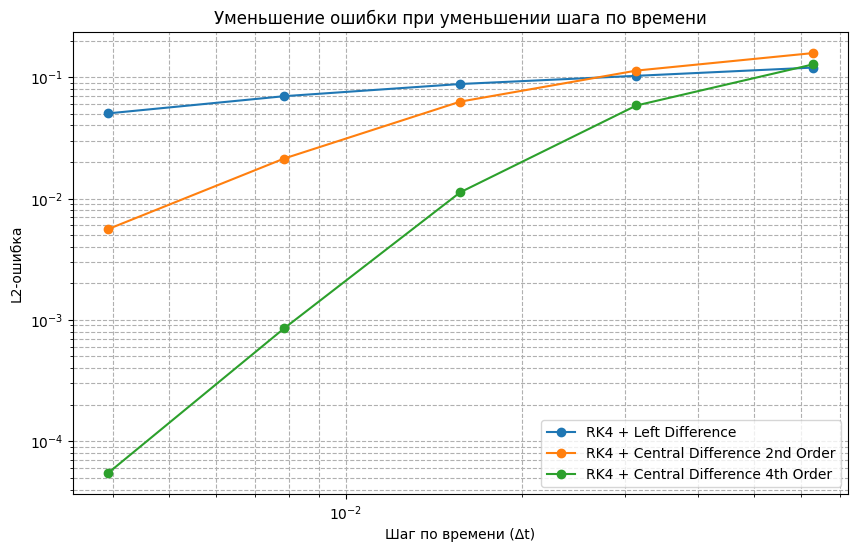

In [ ]:
# Функция для вычисления L2-ошибки
def computeL2Error(u, uExact):
    return np.sqrt(np.mean((u - uExact)**2))

# Параметры
c = 1.0  # Скорость переноса
L = 2 * np.pi  # Длина области
nx_values = [50, 100, 200, 400, 800]  # Число точек по пространству
C = 0.5  # Число Куранта

# Схемы для анализа
schemes = [
    ("RK4 + Left Difference", RK4, leftDifference),
    ("RK4 + Central Difference 2nd Order", RK4, centralDifference2ndOrder),
    ("RK4 + Central Difference 4th Order", RK4, centralDifference4thOrder)
]

# Результаты (ошибки для каждой схемы)
errors = {name: [] for name, _, _ in schemes}
dt_values = []

# Вычисление ошибок
for nx in nx_values:
    dx = L / nx
    dt = C * dx / c  # Шаг по времени
    dt_values.append(dt)

    for name, time_scheme, space_scheme in schemes:
        u, uExact, x, t = solveAdvection(gaussianHill, time_scheme, space_scheme, nx=nx, nt=int(L / dt), L=L, c=c)
        error = computeL2Error(u[-1, :], uExact[-1, :])
        errors[name].append(error)

# Построение графиков
plt.figure(figsize=(10, 6))
for name in errors:
    plt.loglog(dt_values, errors[name], marker='o', label=name)

plt.xlabel("Шаг по времени (Δt)")
plt.ylabel("L2-ошибка")
plt.title("Уменьшение ошибки при уменьшении шага по времени")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

### Упражнение 4
Возьмите сочетание схем, которое вам больше всех нравится и начальное условие Кирпич. Увеличивайте шаг по времени, пока решение не станет неустойчивым. Какое число Куранта критическое?

In [ ]:
def brick(x):
    result = np.zeros_like(x)  # Создаем новый массив для результата
    for i in range(x.size):
        if x[i] < 0.5:
            result[i] = 1
        else:
            result[i] = 0
    return result
u, uExact, x, t = solveAdvection(brick, RK4, leftDifference, nx=100, nt=200)
anim = animateAdvection(u, uExact, x, t)
display(anim)  # Отображаем анимацию в Google Colab

Число Куранта CFL = 0.5


# Фазовая и амплитудная ошибки

Пусть мы используем идеальную схему интегрирования по времени для уравнения переноса. Рассмотрим как переносится начальное условие $A_0\exp\{ikx\}$. Функция такого типа - собственная как для аналитической $\partial/\partial x$, так и для конечных разностей. Важно, что экспонента - элемент Фурье базиса, а все что угодно периодическое раскладывается в ряд Фурье. Мы сейчас будем изучать как себя ведет одна Фурье гармоника.

**Для аналитической** $\partial/\partial x$
\begin{align}
& \frac{\partial }{\partial t}A(t)\exp\{ikx\} =
-c\frac{\partial }{\partial x}A(t)\exp\{ikx\} \\
&\frac{\partial }{\partial t}A(t) =-ikcA(t) \\
& A = \exp\{-ikct\}
\end{align}
аналитическое решение для такого начального условия $f(x,t) = A_0\exp\{ik(x-ct)\}$

**Для конечно-разностной производной** $D$:
\begin{equation}
D\exp\{ikx\} = (k_r+i k_{im})\exp{ikx}
\end{equation}
Решение численной схемы получается
\begin{equation}
f = A_0\exp(-ck_r t)\exp\{ikx - ik_{im}c t\}.
\end{equation}

Если у аппроксимации пространственной производной есть действительная часть $k_r$ то решение будет затухать (левая разность, $c>0$) или неограничено расти (правая разность, $c<0$). Мнимая часть собственного числа как правило $k_{im}\le k$. Т.е. численное решение отстает от истинного, причем, чем больше $k$ (длина волны короче), тем хуже.